# Propofol Data

NESS 2023

Emily Stephen

This notebook contains some example code for working with the propofol data.

In [1]:
import numpy as np
import scipy
import os.path as op
import matplotlib.pyplot as plt
from spectral_connectivity import Multitaper
from spectral_connectivity import Connectivity


This folder contains three files, each with 30 seconds of 
EEG data from a healthy subject during propofol‑induced unconsciousness:
-  `eeganes07laplac250_detrend_all_t180.mat` Awake, before propofol induction
-  `eeganes07laplac250_detrend_all_t3070.mat` Unconscious, at a low dose of propofol
-  `eeganes07laplac250_detrend_all_t4710.mat` Unconscious, at a high dose of propofol

The contents of each file are:
- `y`: (7500,64) The EEG voltage signals (in uV)
- `Fs`: the sampling frequency in Hz (250)
- `ta`: (7500,) the time axis
- `egrid_1indexed`: A grid layout of the electrodes for visualization, where the first electrode has index 1 (i.e. to convert to python indexing you would need to subtract 1 from the indices).

Propofol anesthesia is characterized by two rhythms꞉ a slow
wave (<1 Hz) and an alpha rhythm (~10 Hz). 

Indices (0-indexed) of good example electrodes
- Frontal electrode with good propofol alpha: 41
- Occipital electrode with good awake alpha: 52

## Load and plot the data

### Load

In [2]:
segment_names = ['Awake','Low Dose','High Dose']
segment_strings = ['t180','t3070','t4710']
filepaths = [f'../data/eeganes07laplac250_detrend_all_{tmin}.mat' for 
             tmin in segment_strings]

datadicts = []
for name,f in zip(segment_names,filepaths):
    l = scipy.io.loadmat(f,squeeze_me=True)
    l['name'] = name
    datadicts.append(l)
    
Fs = datadicts[0]['Fs']
egrid_0indexed = datadicts[0]['egrid_1indexed']-1

### Plot the grid with the electrode layout

Plotting this way will lay out the electrodes as though looking down at the 
top of the head, with the nose in front.

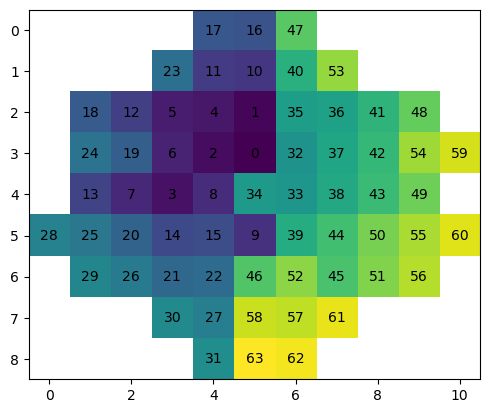

In [3]:
# Show visualization grid

plt.figure()
plt.imshow(egrid_0indexed)
for i in range(egrid_0indexed.shape[0]):
    for j in range(egrid_0indexed.shape[1]):
        if ~np.isnan(egrid_0indexed[i,j]):
            plt.text(j,i,f'{egrid_0indexed[i,j]:0.0f}',
                     ha='center',va='center')

### Plot the timeseries

Text(0.5, 0, 'Time (s)')

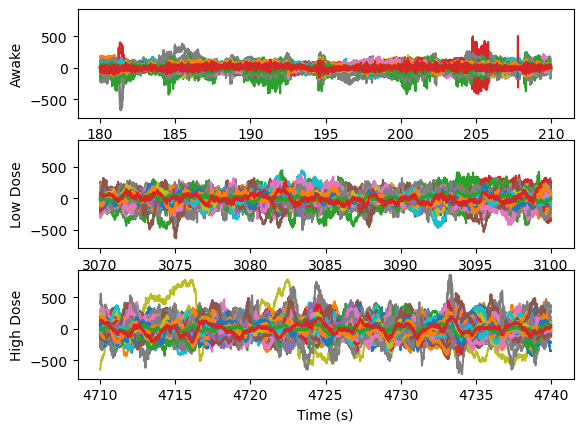

In [4]:
[fig,axs] = plt.subplots(3,1,sharey=True)
for ax,l in zip(axs,datadicts):
    ax.plot(l['ta'], l['y'])
    ax.set_ylabel(l['name'])
axs[-1].set_xlabel('Time (s)')

### Plot the power spectra

In [5]:
# Compute power spectra

TW=5
ntapers = 8

for l in datadicts:
    m = Multitaper(l['y'],
                sampling_frequency=Fs,
                time_halfbandwidth_product=TW,
                n_tapers=ntapers,
                start_time=l['ta'][0])
    c = Connectivity(fourier_coefficients=m.fft(),
                frequencies=m.frequencies,
                time=m.time)
    l['S'] = c.power().squeeze()
    l['fa'] = c.frequencies
    
fa = datadicts[0]['fa']



Text(0, 0.5, 'Power (dB)')

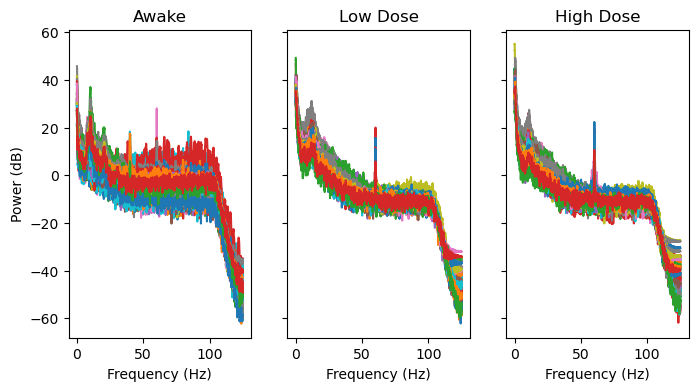

In [6]:
[fig,axs] = plt.subplots(1,3,sharey=True,sharex=True,figsize=[8,4])
for ax,l in zip(axs,datadicts):
    ax.plot(fa, 10*np.log10(l['S']))
    ax.set_title(l['name'])
    ax.set_xlabel('Frequency (Hz)')
axs[0].set_ylabel('Power (dB)')

Text(0, 0.5, 'Power (dB)')

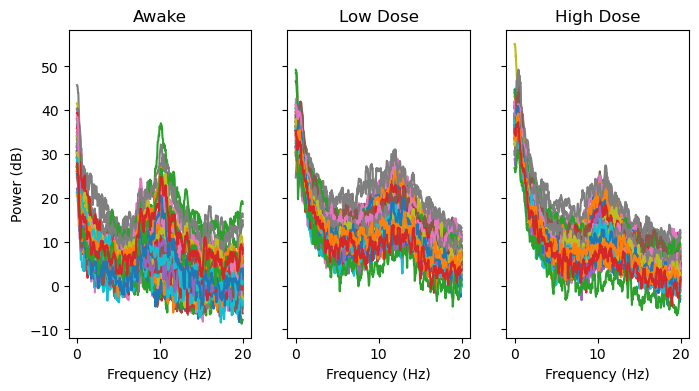

In [7]:
fmask = fa<20
[fig,axs] = plt.subplots(1,3,sharey=True,sharex=True,figsize=[8,4])
for ax,l in zip(axs,datadicts):
    ax.plot(fa[fmask], 10*np.log10(l['S'][fmask,:]))
    ax.set_title(l['name'])
    ax.set_xlabel('Frequency (Hz)')
axs[0].set_ylabel('Power (dB)')


### Plot the alpha and slow power as topo plots

The slow power should increase over all electrodes from awake to low dose to high dose

The alpha power should be occipital for awake and frontal for low/high dose

In [8]:
def convert_grid(vec):
    # Input: 
    #    vec: (64,)
    # Returns:
    #    grid: (9,11) layout of the data in vec using egrid_0indexed
    grid = vec[egrid_0indexed.astype(int)]
    grid[np.isnan(egrid_0indexed)] = np.nan
    return grid

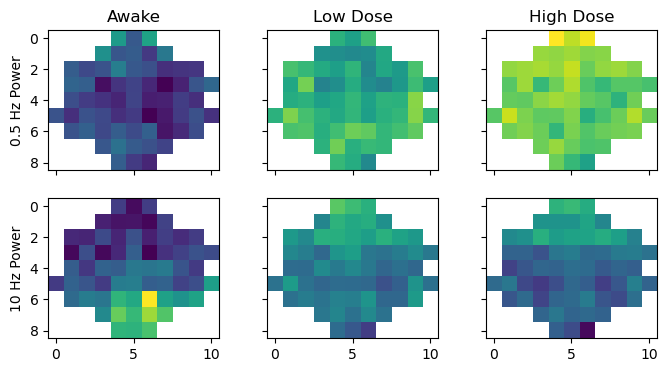

In [9]:
# Plot electrode grids of alpha and slow power

fsel = [0.5,10] 

[fig,axs] = plt.subplots(2,3,sharey=True,sharex=True,figsize=[8,4])
for i,f in enumerate(fsel):
    f_ind = np.argmin(np.abs(fa-f)) # Closest index to f
    
    toplot = [10*np.log10(l['S'][f_ind,:]) for l in datadicts]
    vmin = np.min(toplot)
    vmax = np.max(toplot)
    
    for j,(vec,name) in enumerate(zip(toplot,segment_names)):
        specgrid = convert_grid(vec)
        axs[i,j].imshow(specgrid,vmin=vmin,vmax=vmax)
        if i==0:
            axs[i,j].set_title(name)
    axs[i,0].set_ylabel(f'{f} Hz Power')
